DBSCAN - Density-Based Spatial Clustering of Applications with Noise.

Finds core samples of high density and expands clusters from them. 
Good for data which contains clusters of similar density.

In [1]:
import numpy as np
import math

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

from qupath_processing.io import (
    read_qupath_annotations, read_cells_coordinate,
    )

from collections import defaultdict,  Counter
from os import listdir
from os.path import isfile, join
from itertools import islice
import csv
import geojson
import pandas as pd
import openpyxl
from qupath_processing.utilities import NotValidImage
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon



In [2]:
def get_angle(p1, p2) -> float:
    """Get the angle of this line with the horizontal axis."""
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    theta = math.atan2(dy, dx)
    #angle = math.degrees(theta)  # angle is in (-180, 180]
    if theta < 0:
        theta = math.pi * 2  + theta
    return theta

In [3]:
def read_annotation(annotation_position_file_path):
    df_annotation = read_cells_information(annotation_position_file_path)
    position={}
    for point_str in ['TOP_LEFT', 'TOP_RIGHT', 'BOTTOM_RIGHT', 'BOTTOM_FEFT']:
        annotation = df_annotation[df_annotation["Name"] == point_str]
        position[point_str] = [annotation['Centroid X µm'].to_numpy(dtype=float),
                               annotation['Centroid Y µm'].to_numpy(dtype=float) ]
    top_left = position['TOP_LEFT']
    top_right = position['TOP_RIGHT'] 
    return np.array(top_left), np.array(top_right)

In [4]:
def read_cells_information(file_path):
    """
    Read file that contains cell positions and create cells centroids x,y position and layer classification
    :param file_path:(str) Path to the file that contains cell positions exported form QuPath
    :return:
        tuple:
            - cells_centroid_x np.array of shape (number of cells, ) of type float
            - cells_centroid_y np.array of shape (number of cells, ) of type float
            - layer_classification
    """
    workbook = openpyxl.Workbook()
    worksheets = workbook.worksheets[0]

    with open(file_path, 'r', encoding="utf-8") as data:
        reader = csv.reader(data, delimiter='\t')
        for row in reader:
            worksheets.append(row)
    data = worksheets.values
    cols = next(data)[1:]
    data = list(data)
    idx = [r[0] for r in data]
    data = (islice(r, 1, None) for r in data)
    df = pd.DataFrame(data, index=idx, columns=cols)
    return df

In [5]:
def clustering(layer_name, X, _eps=100, log=False, figure=False):
    labels_true = []
    labels_true.extend([layer_name] * X.shape[0])


    # #############################################################################
    # Compute DBSCAN
    db = DBSCAN(eps=_eps, min_samples=10).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    # #############################################################################
    # Plot result
    import matplotlib.pyplot as plt

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    return_coordinates = []
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
        class_member_mask = labels == k
        
        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=3,
        )

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=12,
        )
        
        # KEEP points from the bigger cluster  only
        if len(xy) > len(return_coordinates):
            return_coordinates = xy


    plt.gca().invert_yaxis()
    title = f'{layer_name} keep {len(return_coordinates) / X.shape[0] * 100:.2f} % of original points in main cluster'
    plt.title(title)
    plt.show()    
    return return_coordinates

In [19]:
cell_position_file_path = '/Users/jacquemi/working_dir/Rat_Nissl/QuPath_results/Layer_boundary_prod_test/SLD_0000406.vsi - 20x_01_JPR_v2_done Detections.txt'

In [24]:
s1_pixel_coordinates, quadrilateral_pixel_coordinates, out_of_pia = read_qupath_annotations('/Users/jacquemi/working_dir/Rat_Nissl/QuPath_results/Layer_boundary_prod_test/SLD_0000406.vsi - 20x_01_JPR_v2_done_annotations.json')

In [25]:
pixel_size = 0.3460130331522824
top_left = quadrilateral_pixel_coordinates[0] * pixel_size
top_right = quadrilateral_pixel_coordinates[1] * pixel_size

In [26]:
df = read_cells_information(cell_position_file_path)

In [27]:
df

,Name,Class,Parent,ROI,Centroid X µm,Centroid Y µm,Area µm^2,Length µm,Circularity,Solidity,...,Cluster mean: Smoothed: 50 µm: Cluster mean: Smoothed: 50 µm: Cluster mean: Smoothed: 50 µm: Distance to annotation with Layer 6 a µm,Cluster mean: Smoothed: 50 µm: Cluster mean: Smoothed: 50 µm: Cluster mean: Smoothed: 50 µm: Nearby detection counts,Cluster mean: Smoothed: 50 µm: Cluster mean: Smoothed: 50 µm: Cluster mean: Delaunay: Num neighbors,Cluster mean: Smoothed: 50 µm: Cluster mean: Smoothed: 50 µm: Cluster mean: Delaunay: Mean distance,Cluster mean: Smoothed: 50 µm: Cluster mean: Smoothed: 50 µm: Cluster mean: Delaunay: Median distance,Cluster mean: Smoothed: 50 µm: Cluster mean: Smoothed: 50 µm: Cluster mean: Delaunay: Max distance,Cluster mean: Smoothed: 50 µm: Cluster mean: Smoothed: 50 µm: Cluster mean: Delaunay: Min distance,Cluster mean: Smoothed: 50 µm: Cluster mean: Smoothed: 50 µm: Cluster mean: Delaunay: Mean triangle area,Cluster mean: Smoothed: 50 µm: Cluster mean: Smoothed: 50 µm: Cluster mean: Delaunay: Max triangle area,Cluster mean: Smoothed: 50 µm: Cluster mean: Smoothed: 50 µm: Cluster size
SLD_0000406.vsi - 20x_01_JPR_v2_done,Layer 5,Layer 5,S1HL,Polygon,10224.4,1704.2,590.7276,116.9543,0.5427,0.9395,...,400.9574,28.4113,5.9927,18.6332,18.145,28.0832,10.3995,133.4137,244.5613,11801.001
SLD_0000406.vsi - 20x_01_JPR_v2_done,Layer 4,Layer 4,S1HL,Polygon,10335.2,1526.9,493.9864,119.7207,0.4331,0.892,...,400.9574,28.4113,5.9927,18.6332,18.145,28.0832,10.3995,133.4137,244.5613,11801.001
SLD_0000406.vsi - 20x_01_JPR_v2_done,Layer 4,Layer 4,S1HL,Polygon,11415.5,1355.4,493.5086,110.031,0.5122,0.951,...,400.9574,28.4113,5.9927,18.6332,18.145,28.0832,10.3995,133.4137,244.5613,11801.001
SLD_0000406.vsi - 20x_01_JPR_v2_done,Layer 5,Layer 5,S1HL,Polygon,11367.6,1511.3,470.8806,107.2654,0.5143,0.947,...,400.9574,28.4113,5.9927,18.6332,18.145,28.0832,10.3995,133.4137,244.5613,11801.001
SLD_0000406.vsi - 20x_01_JPR_v2_done,Layer 5,Layer 5,S1HL,Polygon,10318.3,1668.4,467.0482,105.1882,0.5304,0.9611,...,400.9574,28.4113,5.9927,18.6332,18.145,28.0832,10.3995,133.4137,244.5613,11801.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SLD_0000406.vsi - 20x_01_JPR_v2_done,Layer 6 a,Layer 6 a,S1HL,Polygon,10037.2,2195,6.465,11.7651,0.5869,0.9,...,400.9574,28.4113,5.9927,18.6332,18.145,28.0832,10.3995,133.4137,244.5613,11801.001
SLD_0000406.vsi - 20x_01_JPR_v2_done,Layer 1,Layer 1,S1HL,Polygon,10168.2,848.01,6.2265,11.7654,0.5652,0.8889,...,400.9574,28.4113,5.9927,18.6332,18.145,28.0832,10.3995,133.4137,244.5613,11801.001
SLD_0000406.vsi - 20x_01_JPR_v2_done,Layer 6 a,Layer 6 a,S1HL,Polygon,10155.3,2466.6,6.2263,11.7656,0.5652,0.8965,...,400.9574,28.4113,5.9927,18.6332,18.145,28.0832,10.3995,133.4137,244.5613,11801.001
SLD_0000406.vsi - 20x_01_JPR_v2_done,Layer 6 a,Layer 6 a,S1HL,Polygon,10882.6,2202.1,6.2254,13.1484,0.4525,0.8813,...,400.9574,28.4113,5.9927,18.6332,18.145,28.0832,10.3995,133.4137,244.5613,11801.001


In [28]:
layer_points = {}
for layer_name in ['Layer 1',
                   'Layer 2',
                   'Layer 3',
                   'Layer 4',
                   'Layer 5',
                   'Layer 6 a',
                   'Layer 6 b']:
    layer = df[df["Class"] == layer_name]
    Xs = layer['Centroid X µm'].to_numpy(dtype=float) 
    Ys = layer['Centroid Y µm'].to_numpy(dtype=float) 
    layer_points[layer_name] = np.column_stack((Xs,Ys))

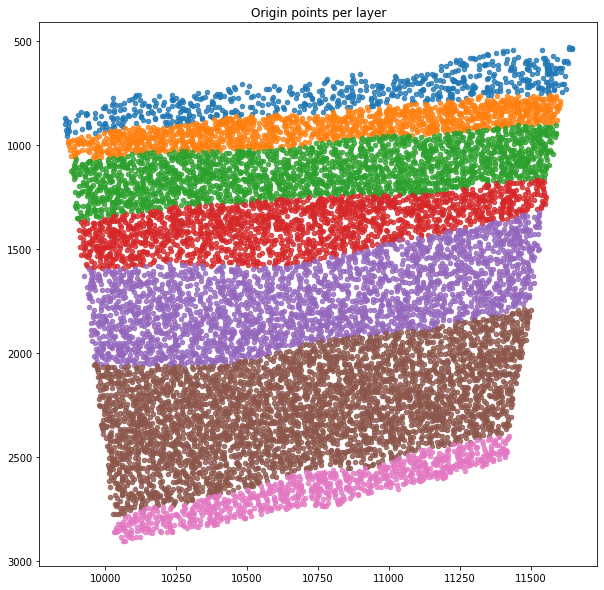

In [30]:
plt.figure(figsize=(10,10))
plt.gca().invert_yaxis()
x_values = [top_left[0], top_right[0]]
y_values = [top_left[1], top_right[1]]
#plt.plot(x_values, y_values, c='black')

for XY in layer_points.values() :
    plt.scatter(XY[:,0], XY[:,1], s=20, alpha=0.8)
plt.title('Origin points per layer') 
plt.show()

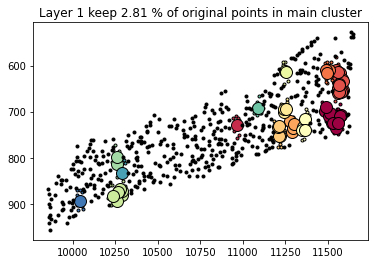

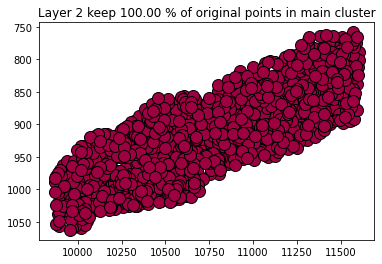

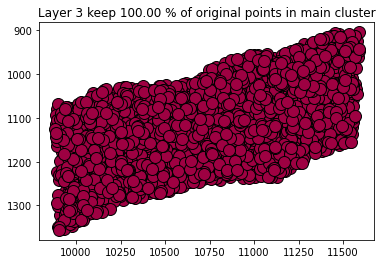

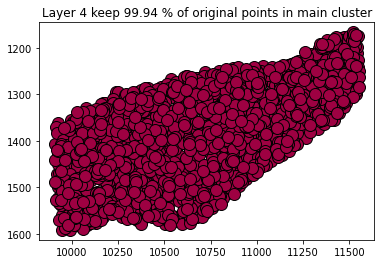

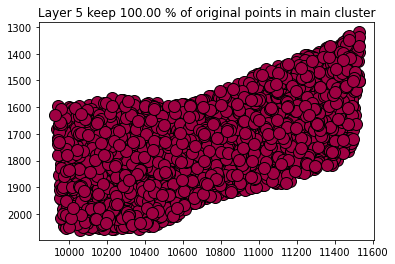

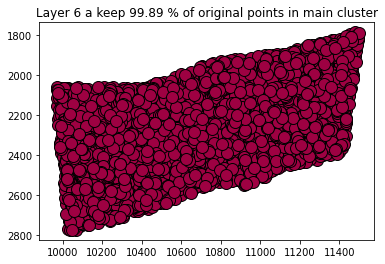

KeyError: 'Layer 6b'

In [31]:
layer_clustered_points={}
layer_list =  ['Layer 1', 'Layer 2','Layer 3','Layer 4','Layer 5','Layer 6 a','Layer 6b']
layer_dbscan_eps=  [30, 80, 80, 50, 100, 50, 400]
                    

for layer_name , eps_value in zip(layer_list, layer_dbscan_eps):
    if layer_points[layer_name].size >0:
        layer_clustered_points[layer_name] = clustering(layer_name, layer_points[layer_name],  
                                                      eps_value, log=True,  figure=True)


Layer Layer 1
Layer Layer 2
Layer Layer 3
Layer Layer 4
Layer Layer 5
Layer Layer 6 a


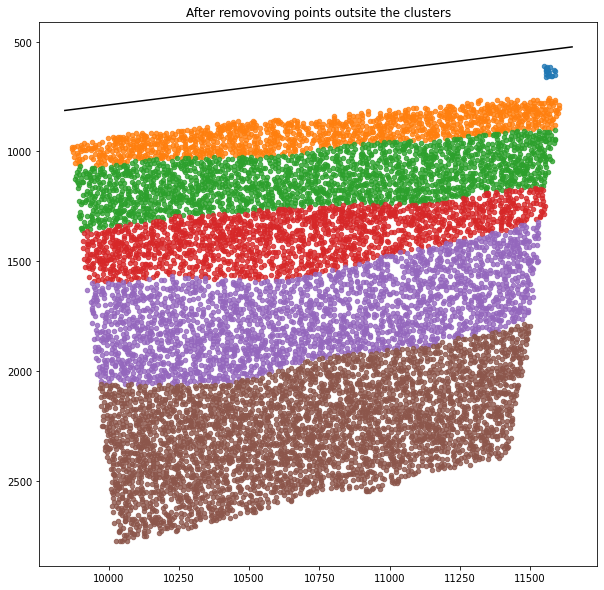

In [32]:
plt.figure(figsize=(10,10))
plt.gca().invert_yaxis()
x_values = [top_left[0], top_right[0]]
y_values = [top_left[1], top_right[1]]
plt.plot(x_values, y_values, c='black')

for layer_name, XY in layer_clustered_points.items() :
    print(f'Layer {layer_name}')
    plt.scatter(XY[:,0], XY[:,1], s=20, alpha=0.8)
    plt.title('After removoving points outsite the clusters') 
plt.show()

# ROTATION

In [135]:
def rotate_points_list(points, theta):
    rotated_point=points.copy()
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    rotated_point = np.dot(rotated_point, R.T)
    return rotated_point

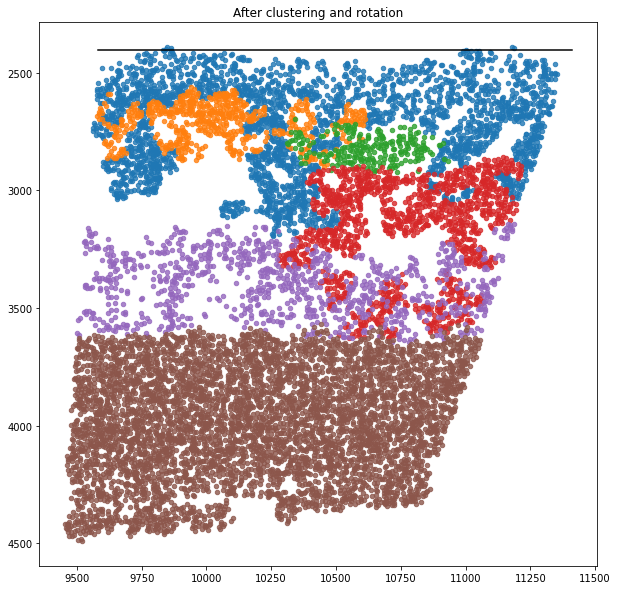

In [136]:
theta = - get_angle(top_left, top_right)
layer_rotatated_points = {}
for label_eps, XY in layer_clustered_points.items():
    layer_rotatated_points[label_eps] = rotate_points_list(XY, theta)

top_points = np.array([top_left, top_right]).reshape(-1,2)
rotated_points = rotate_points_list(top_points, theta)

plt.figure(figsize=(10,10))

x_values = [rotated_points[0][0], rotated_points[1][0]]
y_values = [rotated_points[0][1], rotated_points[1][1]]
plt.plot(x_values, y_values, c='black')

plt.gca().invert_yaxis()
for XY in layer_rotatated_points.values() :
    plt.scatter(XY[:,0], XY[:,1], s=20, alpha=0.8)
plt.title('After clustering and rotation')
plt.show()

Layer 1 	 boundery  19.89 um from top of layer 1
Layer 2 	 boundery  197.12 um from top of layer 1
Layer 3 	 boundery  346.47 um from top of layer 1
Layer 4 	 boundery  494.65 um from top of layer 1
Layer 5 	 boundery  774.77 um from top of layer 1
Layer 6 a 	 boundery  1202.99 um from top of layer 1


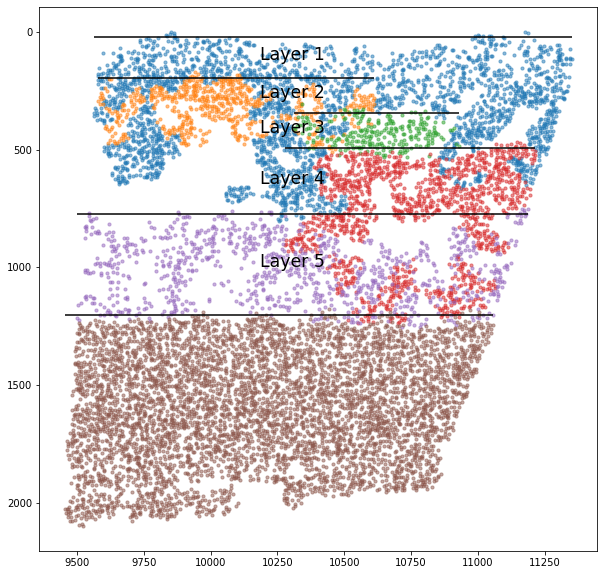

In [137]:
plt.figure(figsize=(10,10))


y_origin = layer_rotatated_points['Layer 1'][:,1].min()

final_result = {}
y_lines = []
plt.gca().invert_yaxis()
for label_eps, XY in layer_rotatated_points.items() :
    plt.scatter(XY[:,0], XY[:,1]-y_origin, s=10, alpha=.5)
    y_coors = XY[:,1]
    x_coors = XY[:,0]

    
    layer_ymin = y_coors[y_coors.argsort()[0:30]].mean()
    layer_ymax = y_coors[y_coors.argsort()[-30:-1]].mean()
    layer_ymean = (layer_ymax + layer_ymin) / 2
    xmean =  x_coors.mean()
    y_lines.append(layer_ymin)
    plt.hlines(layer_ymin-y_origin,  XY[:,0].min(),  XY[:,0].max(), color='black')
    final_result[label_eps] = layer_ymin  - y_origin

if 'Layer 6b' in layer_rotatated_points:
    y_lines.append(layer_rotatated_points['Layer 6b'][:,1].max())
    
half_letter_size = 10
y_0 = y_lines[0]
for y_1, layer_name in zip(y_lines[1:], ['Layer 1', 'Layer 2', 'Layer 3', 'Layer 4','Layer 5',
                           'Layer 6 a', 'Layer 6b']):
    y = (y_0 + y_1)/2
    plt.text(xmean, y-y_origin +  half_letter_size , layer_name, size='xx-large')
    y_0 = y_1
       

for layer, boundery in final_result.items():
    print(f'{layer} \t boundery  {boundery:.2f} um from top of layer 1')    
plt.show()

Text(2, 0, 'local max')

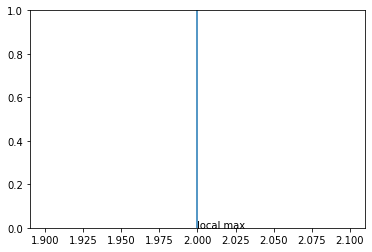

In [47]:
plt.axvline(2)
plt.annotate('local max', xy=(2, 0))